In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.pyplot as plt
from utils import mkdir_p
import glob
from numba import jit
import pickle
import os, errno
import time 

In [2]:
# lcs_t -> indices of LCs in trackster
# lcs_t_layerId -> layerIds of those LCs
# lcs_t_energy -> energies of those LCs
# TO DO: accumulate energy by layer id -> tot_en_lay
@jit(nopython = True)
def get_energy_per_layer(lcs_t_layerId, lcs_t_energy):
    t_hgcal_layers = np.zeros(51) # per layer energy of a trackster 
    for i, e in enumerate(lcs_t_energy):
        layer = lcs_t_layerId[i]
        t_hgcal_layers[layer] += e
        
    return t_hgcal_layers
    
@jit
def findNearestNeighbour(i, barycenters_x, barycenters_y, barycenters_z):
    # find nn, dist to nn for trackster i
    pos_i = np.array([barycenters_x[i], barycenters_y[i], barycenters_z[i]])
    d_least = 1000.
    for k in range(len(barycenters_x)):
        if k == i:
            continue
        pos_k = np.array([barycenters_x[k], barycenters_y[k], barycenters_z[k]])
        del_pos = pos_k - pos_i
        d = np.sqrt(del_pos[0]*del_pos[0] + del_pos[1]*del_pos[1] + del_pos[2]*del_pos[2])
        if d < d_least:
            d_least = d
            i_least = k
    return i_least, d_least
    

def computeEdgeAndLabels(trk_data, ass_data, gra_data, nodes, edges, edges_labels, best_simTs_match):
    '''Compute the truth graph'''
    for i in range(trk_data.NTracksters):
        nodes.append(i)
        qualities = ass_data.tsCLUE3D_recoToSim_CP_score[i]
        best_sts_i = ass_data.tsCLUE3D_recoToSim_CP[i][ak.argmin(qualities)]
        best_simTs_match.append(best_sts_i)
        #best_sts_i = best_sts_i if qualities[best_sts_i]<0.1 else -1
        
        for j in gra_data.linked_inners[i]:
            edges.append([j,i])
            qualities_j = ass_data.tsCLUE3D_recoToSim_CP_score[j]
            best_sts_j = ass_data.tsCLUE3D_recoToSim_CP[j][ak.argmin(qualities_j)]
            #best_sts_j = best_sts_j if qualities[best_sts_j]<0.1 else -1
            if best_sts_i == best_sts_j:
                edges_labels.append(1)
            else:
                edges_labels.append(0)
        
        if len(gra_data.linked_inners[i]) == 0 and len(gra_data.linked_outers[i]) == 0:
            # this trackster does not have any neighbours in the graph, connect it to its nearest neighbour
            b_x = ak.to_numpy(trk_data.barycenter_x)
            b_y = ak.to_numpy(trk_data.barycenter_y)
            b_z = ak.to_numpy(trk_data.barycenter_z)
            nearest_id, nearest_dist = findNearestNeighbour(i, b_x, b_y, b_z)
            edges.append([i, nearest_id])
            qualities_k = ass_data.tsCLUE3D_recoToSim_CP_score[nearest_id]
            best_sts_k = ass_data.tsCLUE3D_recoToSim_CP[nearest_id][ak.argmin(qualities_k)]
            if best_sts_i == best_sts_k:
                edges_labels.append(1)
            else:
                edges_labels.append(0)

In [3]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)    

In [ ]:
#input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/"
input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions_15cm/ntuples_10_600/"

#files = glob.glob(f"{input_folder}/*ntuples_*.root")
files = glob.glob(f"{input_folder}/*merge_*.root")
print(f"{len(files)} files found!")


X = [ ]
Edges = [ ]
Edges_labels = [ ]
enOnLayers = [ ]

outputPath  = './dataset_closeByDoublePion_LC/'
mkdir_p(outputPath)

cum_events = 0

N = 10000
offset = 19
for i_file, file in enumerate(files[offset:]):
    i_file = i_file + offset
    if i_file >= N: break
    try:
        with uproot.open(file) as f:
        #f = uproot.open(file)
            t =  f["ticlNtuplizer/tracksters"]
            calo = f["ticlNtuplizer/simtrackstersCP"]
            ass = f["ticlNtuplizer/associations"]
            gra = f["ticlNtuplizer/graph"]
            l = f['ticlNtuplizer/clusters']

            trk_data = t.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y","barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3","vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"])
            gra_data = gra.arrays(['linked_inners', 'linked_outers'])
            ass_data = ass.arrays([ "tsCLUE3D_recoToSim_CP", "tsCLUE3D_recoToSim_CP_score"])
            lcs_t = t.arrays(['vertices_indexes'])
            lcs = l.arrays(['energy', 'cluster_layer_id'])
            
            print(f"file {file} num events {len(trk_data)}")

    except:
        print("error ", file)
        continue
    print('\nProcessing file {} '.format(file), end="")
    if(cum_events%1000 == 0):
        print(f"\nEvents {cum_events}")
    
    start = time.time()
    for ev in range(len(gra_data)):
        cum_events += 1
        print(".", end="")
        
        trackster_sizes = []
        lcs_ev = lcs[ev]
        tot_en_lay = [] # energy by layer of all tracksters in this event, dim= NTracksters, 51
        
                
        for vertices in trk_data[ev].vertices_indexes:
            # vertices is the list of vertices in a trackster
            trackster_sizes.append(ak.size(vertices))      
            lcs_t = lcs_ev[vertices]
            #lcs_t_layerId = ak.to_numpy(lcs_t.cluster_layer_id)
            #lcs_t_energy = ak.to_numpy(lcs_t.energy)
            tot_en_lay.append(get_energy_per_layer(lcs_t.cluster_layer_id, lcs_t.energy))
        
        #print(f"Ntracksters {trk_data[ev].NTracksters} tot_en_layers shape {np.shape(tot_en_lay)}")

        best_sim_ts = []
        nodes = []
        edges = []
        edges_labels = []        
        computeEdgeAndLabels(trk_data[ev], ass_data[ev], gra_data[ev], nodes, edges, edges_labels, best_sim_ts)
        # Save the input variables
        

        x_ev = ak.zip({  "barycenter_x": trk_data[ev].barycenter_x,
                         "barycenter_y": trk_data[ev].barycenter_y,
                         "barycenter_z": trk_data[ev].barycenter_z,
                       "eVector0_x": trk_data[ev].eVector0_x,
                       "eVector0_y": trk_data[ev].eVector0_y,
                       "eVector0_z": trk_data[ev].eVector0_z,
                       "EV1": trk_data[ev].EV1,
                       "EV2": trk_data[ev].EV2,
                       "EV3": trk_data[ev].EV3,
                       "sigmaPCA1": trk_data[ev].sigmaPCA1,
                       "sigmaPCA2": trk_data[ev].sigmaPCA2,
                       "sigmaPCA3": trk_data[ev].sigmaPCA3,
                       "size": trackster_sizes,
                       "raw_en": trk_data[ev].raw_energy, 
                       'raw_em_energy': trk_data[ev].raw_em_energy,
                       "best_sim_ts" : best_sim_ts
                      })

        X.append(x_ev)        
        
        ed_np = np.array(edges).T
        Edges.append(ed_np)
        Edges_labels.append(edges_labels)     
        enOnLayers.append(tot_en_lay) # accumulates by event
        # Save to disk
        if((len(X) % 500 == 0 and cum_events != 0)):
            stop = time.time()
            print(f"t = {stop-start}")
            print("Saving now the pickle data")

            pickle_dir = outputPath
            with open(pickle_dir+"{}_{}_node_features.pkl".format(str(i_file), str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(X, fp)
            with open(pickle_dir+"{}_{}_edges.pkl".format(str(i_file),str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(Edges, fp)
            with open(pickle_dir+"{}_{}_edges_labels.pkl".format(str(i_file),str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(Edges_labels, fp)
            with open(pickle_dir+"{}_{}_energies_on_layers.pkl".format(str(i_file),str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(enOnLayers, fp)
            
            #Emptying arrays
            ed_np = []
            X = []
            Edges = []
            Edges_labels = []
            enOnLayers = []
            start = time.time()

54 files found!


### Test

(42, 51)
200


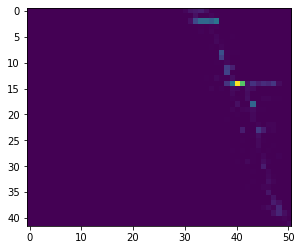

In [22]:
plt.imshow(tot_en_lay)
print(np.shape(tot_en_lay))
print(np.shape(X)[0])

19


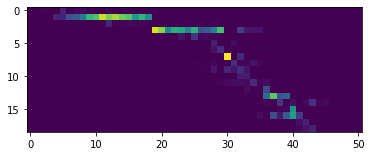

In [19]:
print(len(enOnLayers[99]))
plt.imshow(enOnLayers[99])

In [ ]:
x = X[0]

In [ ]:
plt.plot(np.arange(0,51), x.energy_on_layer[4])